# デモ(犬と猫の識別)

(参考) 
- Kerasのドキュメントページ : https://keras.io/ja
- Convolutional Neural Networkについて : http://qiita.com/icoxfog417/items/5fd55fad152231d706c2

## 1.ライブラリをインポートする（外部の機能を使う準備をする）

In [1]:
#ユーザが指定するべき部分のみコメント（灰色の文字）で示しています
!pip3 install tensorflow keras numpy matplotlib seaborn
#↑インストール
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
sys.path.append('./aitoolkit') 
from aitoolkit import ObjectDetector
from aitoolkit import plot_learning_history
%matplotlib inline
from IPython.display import Image

Using TensorFlow backend.


## 2. モデルの定義をする
- まずは自分で小規模なモデルを作ってみる

In [2]:
from keras.layers import Input, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
import warnings
warnings.filterwarnings('ignore')
#出てくるエラー（W0808とか）は無視してOK

original_detector = ObjectDetector(train_data_dir = './images/train/cat_or_dog/',validation_data_dir = './images/validation/cat_or_dog/',\
                          result_data_dir = 'results/cat_or_dog/')
input_tensor = Input(shape=(150, 150, 3))
x = Convolution2D(48, 11, strides=3, activation='relu', padding='same')(input_tensor)
x = MaxPooling2D(3, strides=2)(x)
x = BatchNormalization()(x)
x = Convolution2D(128, 5, strides=3, activation='relu', padding='same')(x)
x = MaxPooling2D(3, strides=2)(x)
x = BatchNormalization()(x)
x = Convolution2D(192, 3, strides=1, activation='relu', padding='same')(x)
x = Convolution2D(192, 3, strides=1, activation='relu', padding='same')(x)
x = Convolution2D(128, 3, strides=1, activation='relu', padding='same')(x)
x = MaxPooling2D(3, strides=2)(x)
x = BatchNormalization()(x)
conv_model = Model(input=input_tensor, output=x)

W0203 16:52:00.671535 4655830464 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0203 16:52:00.717947 4655830464 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0203 16:52:00.729645 4655830464 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0203 16:52:00.822442 4655830464 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0203 16:52:00.859902 4655830464 deprecation_wrapper.py:119] From /usr/loca

## 3. データセットの定義をする
- batch_size 一度に何枚を学習に利用するか デフォルト 32
- is_augmenting データのオーグメンテーション（水増し）をするならTrue デフォルト:True

In [3]:
#↓ユーザはここを指定
original_detector.create_datasets(batch_size=16, is_augmenting=True)

Found 1908 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
ラベル:
['cat', 'dog']


## 4. 学習をする
- 匂配計算について : http://postd.cc/optimizing-gradient-descent/
- detector.create_model()・detector.compile_model（）について
    - どのようなアルゴリズムで学習するかを決める
    - original_model : 自分で定義したモデルを使う時、ここにmodelを代入する、デフォルト:None
    - batch_norm : Batch Normalizationを使うかどうか、デフォルト:True
    - dropout : Dropoutを使うかどうか、デフォルト:True
    - sgd_lr : SGD（重みを更新するクラス）の学習率(範囲t：t>0.0)、デフォルト：0.01
    - sgd_momentum : SGDのモメンタム（パラメーターの一種）、デフォルト:0.1

- detector.fit()について
    - 実際に学習を行う
    - nb_epoch : 学習にどれくらいのエポックを回すか、デフォルト : 20
    - batch_size : 1バッチでどれくらいの数の画像を使うか、デフォルト：32
    - steps_per_epoch : 1エポックで何ステップの更新を使うか、デフォルト：100
 
- 結果は自動的に出力される

In [4]:
original_detector.create_model(original_model=conv_model, batch_norm = True, dropout = True)
#↓ユーザはここを指定
original_detector.compile_model(sgd_lr=0.01, sgd_momentum=0.1)
#↓ユーザはここ（nb_epoch）を指定
original_detector.fit(nb_epoch = 5, batch_size=16, steps_per_epoch = 50)
original_detector.dump_model_weights('./models/cat_or_dog/model.hdf5')

------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------
Training Finished!!  Total Epoch :::1


## 学習の様子をテキストとグラフに出力する。

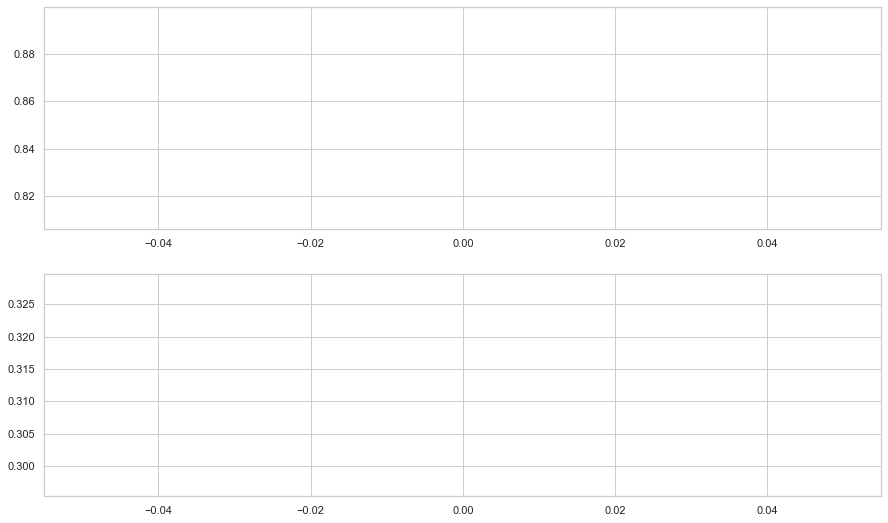

In [5]:
original_detector.output_history('history.txt') # ./results/cat_or_dog/history.txt に保存
plot_learning_history('./results/cat_or_dog/history.txt')

## 1枚の画像で試す

結果 .... にゃー猫だにゃー🐱


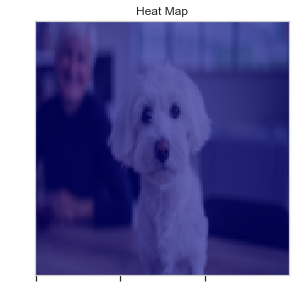

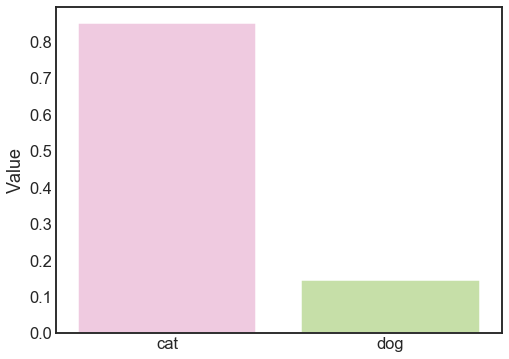

detectメソッドが完了しました．


In [6]:
answer_text = {
    "dog": "犬だよ，ワン🐶",
    "cat": "にゃー猫だにゃー🐱"
}

original_detector.detect(
    "https://ichef.bbci.co.uk/wwfeatures/live/976_549/images/live/p0/7z/n7/p07zn7p7.jpg", 
    answer_text, 
    verbose=True,
    layer_index=3,
    mode="online"
)


# ここからは精度向上の為の発展
## 5. 既存の大規模なモデルを使う

In [7]:
#出てくるエラー（W0808とか）は無視してOK
import warnings
warnings.filterwarnings('ignore')
detector = ObjectDetector(train_data_dir = './images/train/cat_or_dog/',validation_data_dir = './images/validation/cat_or_dog/',\
                          result_data_dir = 'results/cat_or_dog/')
detector.create_model(original_model=None, batch_norm = True, dropout = True)
#↓ユーザはここを指定
detector.compile_model(sgd_lr=0.0008, sgd_momentum=0.9)
#original_model=None で既存のモデルを使う事を選択する

create_modelメソッドが完了しました．
compile_modelメソッドが完了しました．


## 6. Fine-tuningの設定を行う
今回だと、第三者が作ったVGG-16という、1000個の種類の画像を識別するモデルを初期状態として読み込んでいて、そのモデルの中で、どこを学習可能にして、どこを不変にするのかを設定する。Fine-tuningの時は学習率は小さめで良い。

In [8]:
for index in range(15): # 一番上から15番目のレイヤーまで重みを固定する。
    detector.deactivate_layer(index)

## 7.データセットの定義

In [9]:
#↓ユーザはここを指定
detector.create_datasets(batch_size=16, is_augmenting=True)

Found 1908 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
ラベル:
['cat', 'dog']


## 8.学習

In [ ]:
#↓ユーザはここを指定
detector.fit(nb_epoch = 2, batch_size=16, verbose=False, steps_per_epoch = 50)
detector.dump_model_weights('./models/cat_or_dog/model.hdf5')

Validation Sample Number : 20

Epoch 1/2
 3/50 [>.............................] - ETA: 5:49 - loss: 1.1567 - acc: 0.5625

## 学習の様子をテキストとグラフに出力する。

In [ ]:
detector.output_history('history2.txt')
plot_learning_history('./results/cat_or_dog/history2.txt')

## 1枚の画像で試す

In [ ]:
detector.detect(
    "https://upload.wikimedia.org/wikipedia/commons/thumb/9/9e/2016-06-14_Orange_and_white_tabby_cat_born_in_2016_%E8%8C%B6%E3%83%88%E3%83%A9%E7%99%BD%E3%81%AD%E3%81%93_DSCF6526%E2%98%86%E5%BD%A1.jpg/200px-2016-06-14_Orange_and_white_tabby_cat_born_in_2016_%E8%8C%B6%E3%83%88%E3%83%A9%E7%99%BD%E3%81%AD%E3%81%93_DSCF6526%E2%98%86%E5%BD%A1.jpg", 
    answer_text, 
    verbose=True,
    layer_index=3,
    mode="online"
)

## モデルの中身を表示する

In [ ]:
detector.get_model_summary()
for i in range(2):
    detector.show_layer_activation("predictions" , filter_indices=[i])

## 補足.モデルの重みを出力する
- detector.dump_model_weights("出力先のパス")
- "hdf5"という形式にする

In [ ]:
detector.dump_model_weights('./models/cat_or_dog/model.hdf5')

- 一度出力した重みは、read_model_weights()を使って利用できる。

In [ ]:
detector.read_model_weights('./models/cat_or_dog/model.hdf5')